#  Oil/Water Production Prediction
- Using Equinor Production Data, I will attempt to forecast oil and water production with different model of ML.

<table>
  <tr><td>
    <img src="https://the-cradle-media.s3.eu-west-1.amazonaws.com/wp-content/uploads/2023/05/crude-oil-opec-production-cut-scaled-1.jpg"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Oil Production Prediction
  </td></tr>
</table>


Import Libraries

In [234]:
!pip install seaborn mplcyberpunk

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")
import missingno as ms
import mplcyberpunk
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [236]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
rout = "/content/drive/MyDrive/Colab Notebooks/Predictions of well production/Volve production data.xlsx"

df = pd.read_excel(rout)

print(df.head())

     DATEPRD WELL_BORE_CODE  NPD_WELL_BORE_CODE NPD_WELL_BORE_NAME  \
0 2014-04-07  NO 15/9-F-1 C                7405         15/9-F-1 C   
1 2014-04-08  NO 15/9-F-1 C                7405         15/9-F-1 C   
2 2014-04-09  NO 15/9-F-1 C                7405         15/9-F-1 C   
3 2014-04-10  NO 15/9-F-1 C                7405         15/9-F-1 C   
4 2014-04-11  NO 15/9-F-1 C                7405         15/9-F-1 C   

   NPD_FIELD_CODE NPD_FIELD_NAME  NPD_FACILITY_CODE NPD_FACILITY_NAME  \
0         3420717          VOLVE             369304    MÆRSK INSPIRER   
1         3420717          VOLVE             369304    MÆRSK INSPIRER   
2         3420717          VOLVE             369304    MÆRSK INSPIRER   
3         3420717          VOLVE             369304    MÆRSK INSPIRER   
4         3420717          VOLVE             369304    MÆRSK INSPIRER   

   ON_STREAM_HRS  AVG_DOWNHOLE_PRESSURE  ...  AVG_CHOKE_UOM  AVG_WHP_P  \
0            0.0                0.00000  ...              %    0.0

##Check the Data

In [238]:
df["WELL_BORE_CODE"].unique()

array(['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H',
       'NO 15/9-F-14 H', 'NO 15/9-F-15 D', 'NO 15/9-F-4 AH',
       'NO 15/9-F-5 AH'], dtype=object)

Choose one well to produce our model

In [239]:
df = df[df["WELL_BORE_CODE"] == 'NO 15/9-F-15 D']

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978 entries, 8023 to 9000
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATEPRD                   978 non-null    datetime64[ns]
 1   WELL_BORE_CODE            978 non-null    object        
 2   NPD_WELL_BORE_CODE        978 non-null    int64         
 3   NPD_WELL_BORE_NAME        978 non-null    object        
 4   NPD_FIELD_CODE            978 non-null    int64         
 5   NPD_FIELD_NAME            978 non-null    object        
 6   NPD_FACILITY_CODE         978 non-null    int64         
 7   NPD_FACILITY_NAME         978 non-null    object        
 8   ON_STREAM_HRS             978 non-null    float64       
 9   AVG_DOWNHOLE_PRESSURE     978 non-null    float64       
 10  AVG_DOWNHOLE_TEMPERATURE  978 non-null    float64       
 11  AVG_DP_TUBING             978 non-null    float64       
 12  AVG_ANNULUS_PRESS      

In [241]:
df.describe()

,DATEPRD,NPD_WELL_BORE_CODE,NPD_FIELD_CODE,NPD_FACILITY_CODE,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL
count,978,978.0,978.0,978.0,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,0.0
mean,2015-05-17 10:56:41.226993920,7289.0,3420717.0,369304.0,18.225800,226.034913,104.645541,186.151814,13.961934,9.984839,39.883098,28.597811,17.107177,151.859468,23011.606288,53.544376,NaN
min,2014-01-12 00:00:00,7289.0,3420717.0,369304.0,0.000000,193.187243,45.771320,153.683049,0.000000,0.000000,0.000000,0.000000,0.009590,0.000000,0.000000,0.000000,NaN
25%,2014-09-15 06:00:00,7289.0,3420717.0,369304.0,15.612497,200.058327,106.076582,159.357986,10.313505,3.461283,28.313615,23.634434,4.860698,108.537500,16886.387500,0.000000,NaN
50%,2015-05-17 12:00:00,7289.0,3420717.0,369304.0,24.000000,202.245095,106.431873,170.393829,15.394031,10.516468,37.639551,29.836432,11.487939,175.330000,27023.825000,6.060000,NaN
75%,2016-01-16 18:00:00,7289.0,3420717.0,369304.0,24.000000,228.976683,106.576375,184.564635,19.006197,12.020442,44.507606,37.347585,15.440892,212.255000,32214.805000,113.435000,NaN
max,2016-09-17 00:00:00,7289.0,3420717.0,369304.0,24.000000,397.588550,107.043953,345.906770,28.487663,43.017037,118.127270,51.252433,109.781900,513.120000,77600.880000,352.290000,NaN
std,NaN,0.0,0.0,0.0,9.909770,42.718914,4.759651,47.941926,7.050640,6.757359,24.280447,13.122976,21.740978,97.630266,14672.708772,86.791968,NaN


In [242]:
df.isna().sum()

,0
DATEPRD,0
WELL_BORE_CODE,0
NPD_WELL_BORE_CODE,0
NPD_WELL_BORE_NAME,0
NPD_FIELD_CODE,0
NPD_FIELD_NAME,0
NPD_FACILITY_CODE,0
NPD_FACILITY_NAME,0
ON_STREAM_HRS,0
AVG_DOWNHOLE_PRESSURE,0


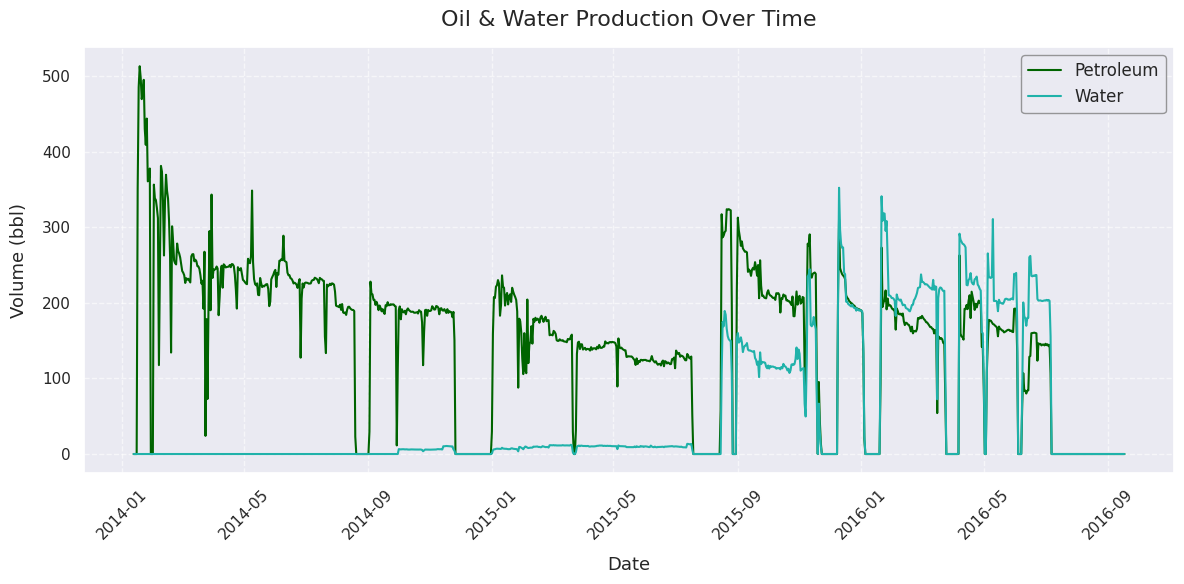

In [243]:
fig, ax = plt.subplots(figsize=(12,6), facecolor="white")

# Graficar líneas con más grosor y marcadores
ax.plot(df["DATEPRD"], df["BORE_OIL_VOL"], color="darkgreen", label="Petroleum")
ax.plot(df["DATEPRD"], df["BORE_WAT_VOL"], color="lightseagreen", label="Water")

# Etiquetas
ax.set_xlabel("Date", fontsize=13, labelpad=10)
ax.set_ylabel("Volume (bbl)", fontsize=13, labelpad=10)

# Agregar título con más separación
ax.set_title("Oil & Water Production Over Time", fontsize=16, pad=15)

# Mejorar la leyenda
ax.legend(fontsize=12, loc="upper right", frameon=True, edgecolor="gray")

# Agregar grid discreto
ax.grid(True, linestyle="--", alpha=0.6)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Ajustar márgenes
plt.tight_layout()

# Mostrar gráfico
plt.show()

Clean the n/a from our data

In [244]:
df= df[
    ['DATEPRD','ON_STREAM_HRS','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','AVG_DP_TUBING'
     ,'AVG_WHP_P','AVG_WHT_P','DP_CHOKE_SIZE','BORE_OIL_VOL', 'BORE_WAT_VOL']
].dropna()

In [245]:
df.isna().sum()

,0
DATEPRD,0
ON_STREAM_HRS,0
AVG_DOWNHOLE_PRESSURE,0
AVG_DOWNHOLE_TEMPERATURE,0
AVG_DP_TUBING,0
AVG_WHP_P,0
AVG_WHT_P,0
DP_CHOKE_SIZE,0
BORE_OIL_VOL,0
BORE_WAT_VOL,0


Compute production rates from oil and water volume data

In [246]:

df = df[df["ON_STREAM_HRS"] > 0]
df["oil_rate"] = (df["BORE_OIL_VOL"] / df["ON_STREAM_HRS"])
df["water_rate"] = (df["BORE_WAT_VOL"] / df["ON_STREAM_HRS"])
df.drop(columns=["ON_STREAM_HRS"],inplace=True)

In [247]:
df.drop(columns=["BORE_OIL_VOL","BORE_WAT_VOL"],inplace=True)

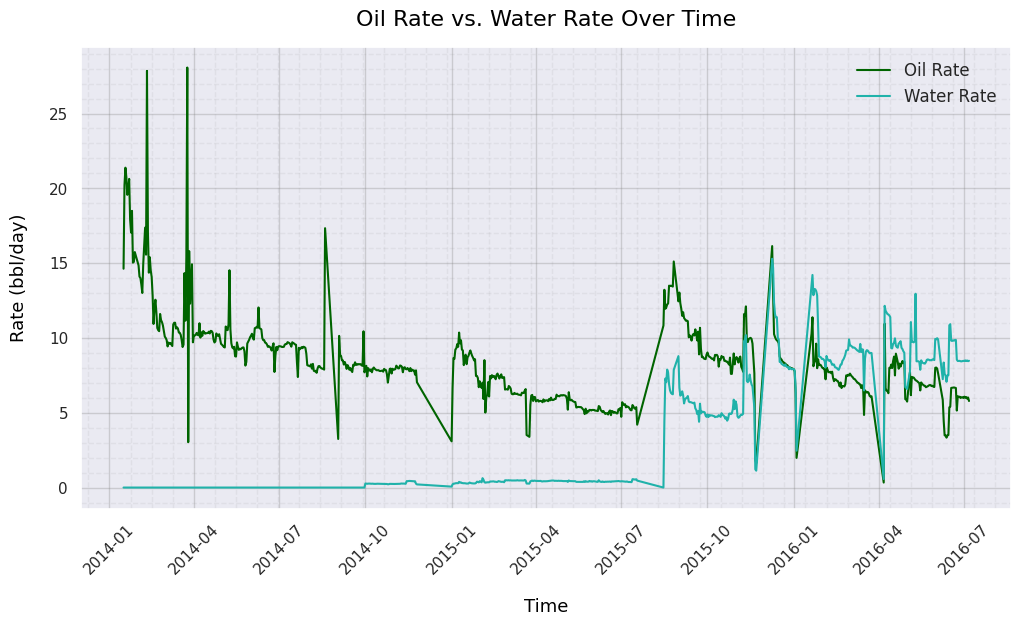

In [248]:
df_filtered = df[(df["oil_rate"] > 0) | (df["water_rate"] > 0)]

plt.figure(figsize=(12, 6))

plt.plot(df_filtered["DATEPRD"], df_filtered["oil_rate"],
         color="darkgreen", label="Oil Rate")

plt.plot(df_filtered["DATEPRD"], df_filtered["water_rate"],
         color="lightseagreen", label="Water Rate")

plt.xlabel("Time", fontsize=13, labelpad=15, color="black")
plt.ylabel("Rate (bbl/day)", fontsize=13, labelpad=15, color="black")

plt.title("Oil Rate vs. Water Rate Over Time", fontsize=16, pad=15, loc="center", color="black")

plt.grid(visible=True, which="major", linestyle="-", alpha=0.3, color="gray")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle="--", alpha=0.1, color="gray")

plt.xticks(rotation=45)

plt.legend(facecolor="white", framealpha=1, fontsize=12)

plt.show()

Remove outlier with IQR

In [249]:
Q1 = df["oil_rate"].quantile(0.25)
Q3 = df["oil_rate"].quantile(0.75)
IQR = Q3 - Q1

df = df[(df["oil_rate"] >= Q1 - 1.5 * IQR) &
                          (df["oil_rate"] <= Q3 + 1.5 * IQR)]
Q1 = df["water_rate"].quantile(0.25)
Q3 = df["water_rate"].quantile(0.75)
IQR = Q3 - Q1

df = df[(df["water_rate"] >= Q1 - 1.5 * IQR) &
                          (df["water_rate"] <= Q3 + 1.5 * IQR)]

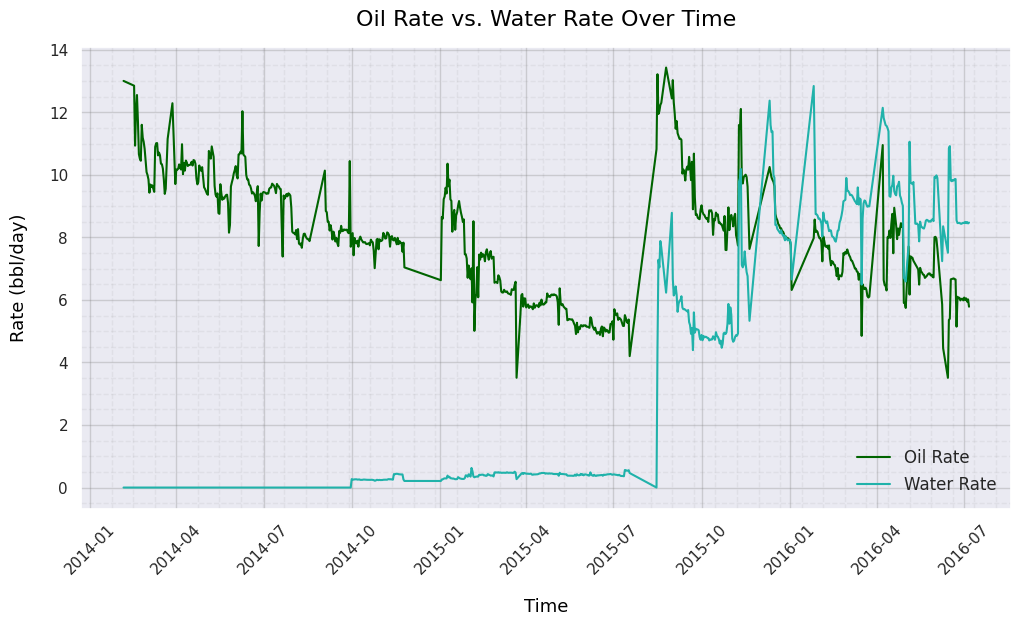

In [250]:
low_oil, high_oil = df["oil_rate"].quantile([0.01, 0.99])
df = df[(df["oil_rate"] >= low_oil) & (df["oil_rate"] <= high_oil)]

low_water, high_water = df["water_rate"].quantile([0.01, 0.99])
df = df[(df["water_rate"] >= low_water) & (df["water_rate"] <= high_water)]

plt.figure(figsize=(12, 6))

plt.plot(df["DATEPRD"], df["oil_rate"], color="darkgreen", label="Oil Rate")
plt.plot(df["DATEPRD"], df["water_rate"], color="lightseagreen", label="Water Rate")

plt.xlabel("Time", fontsize=13, labelpad=15, color="black")
plt.ylabel("Rate (bbl/day)", fontsize=13, labelpad=15, color="black")

plt.title("Oil Rate vs. Water Rate Over Time", fontsize=16, pad=15, loc="center", color="black")

plt.grid(visible=True, which="major", linestyle="-", alpha=0.3, color="gray")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle="--", alpha=0.1, color="gray")

plt.xticks(rotation=45)

plt.legend(facecolor="white", framealpha=1, fontsize=12)

plt.show()

Scatter plots between all variables

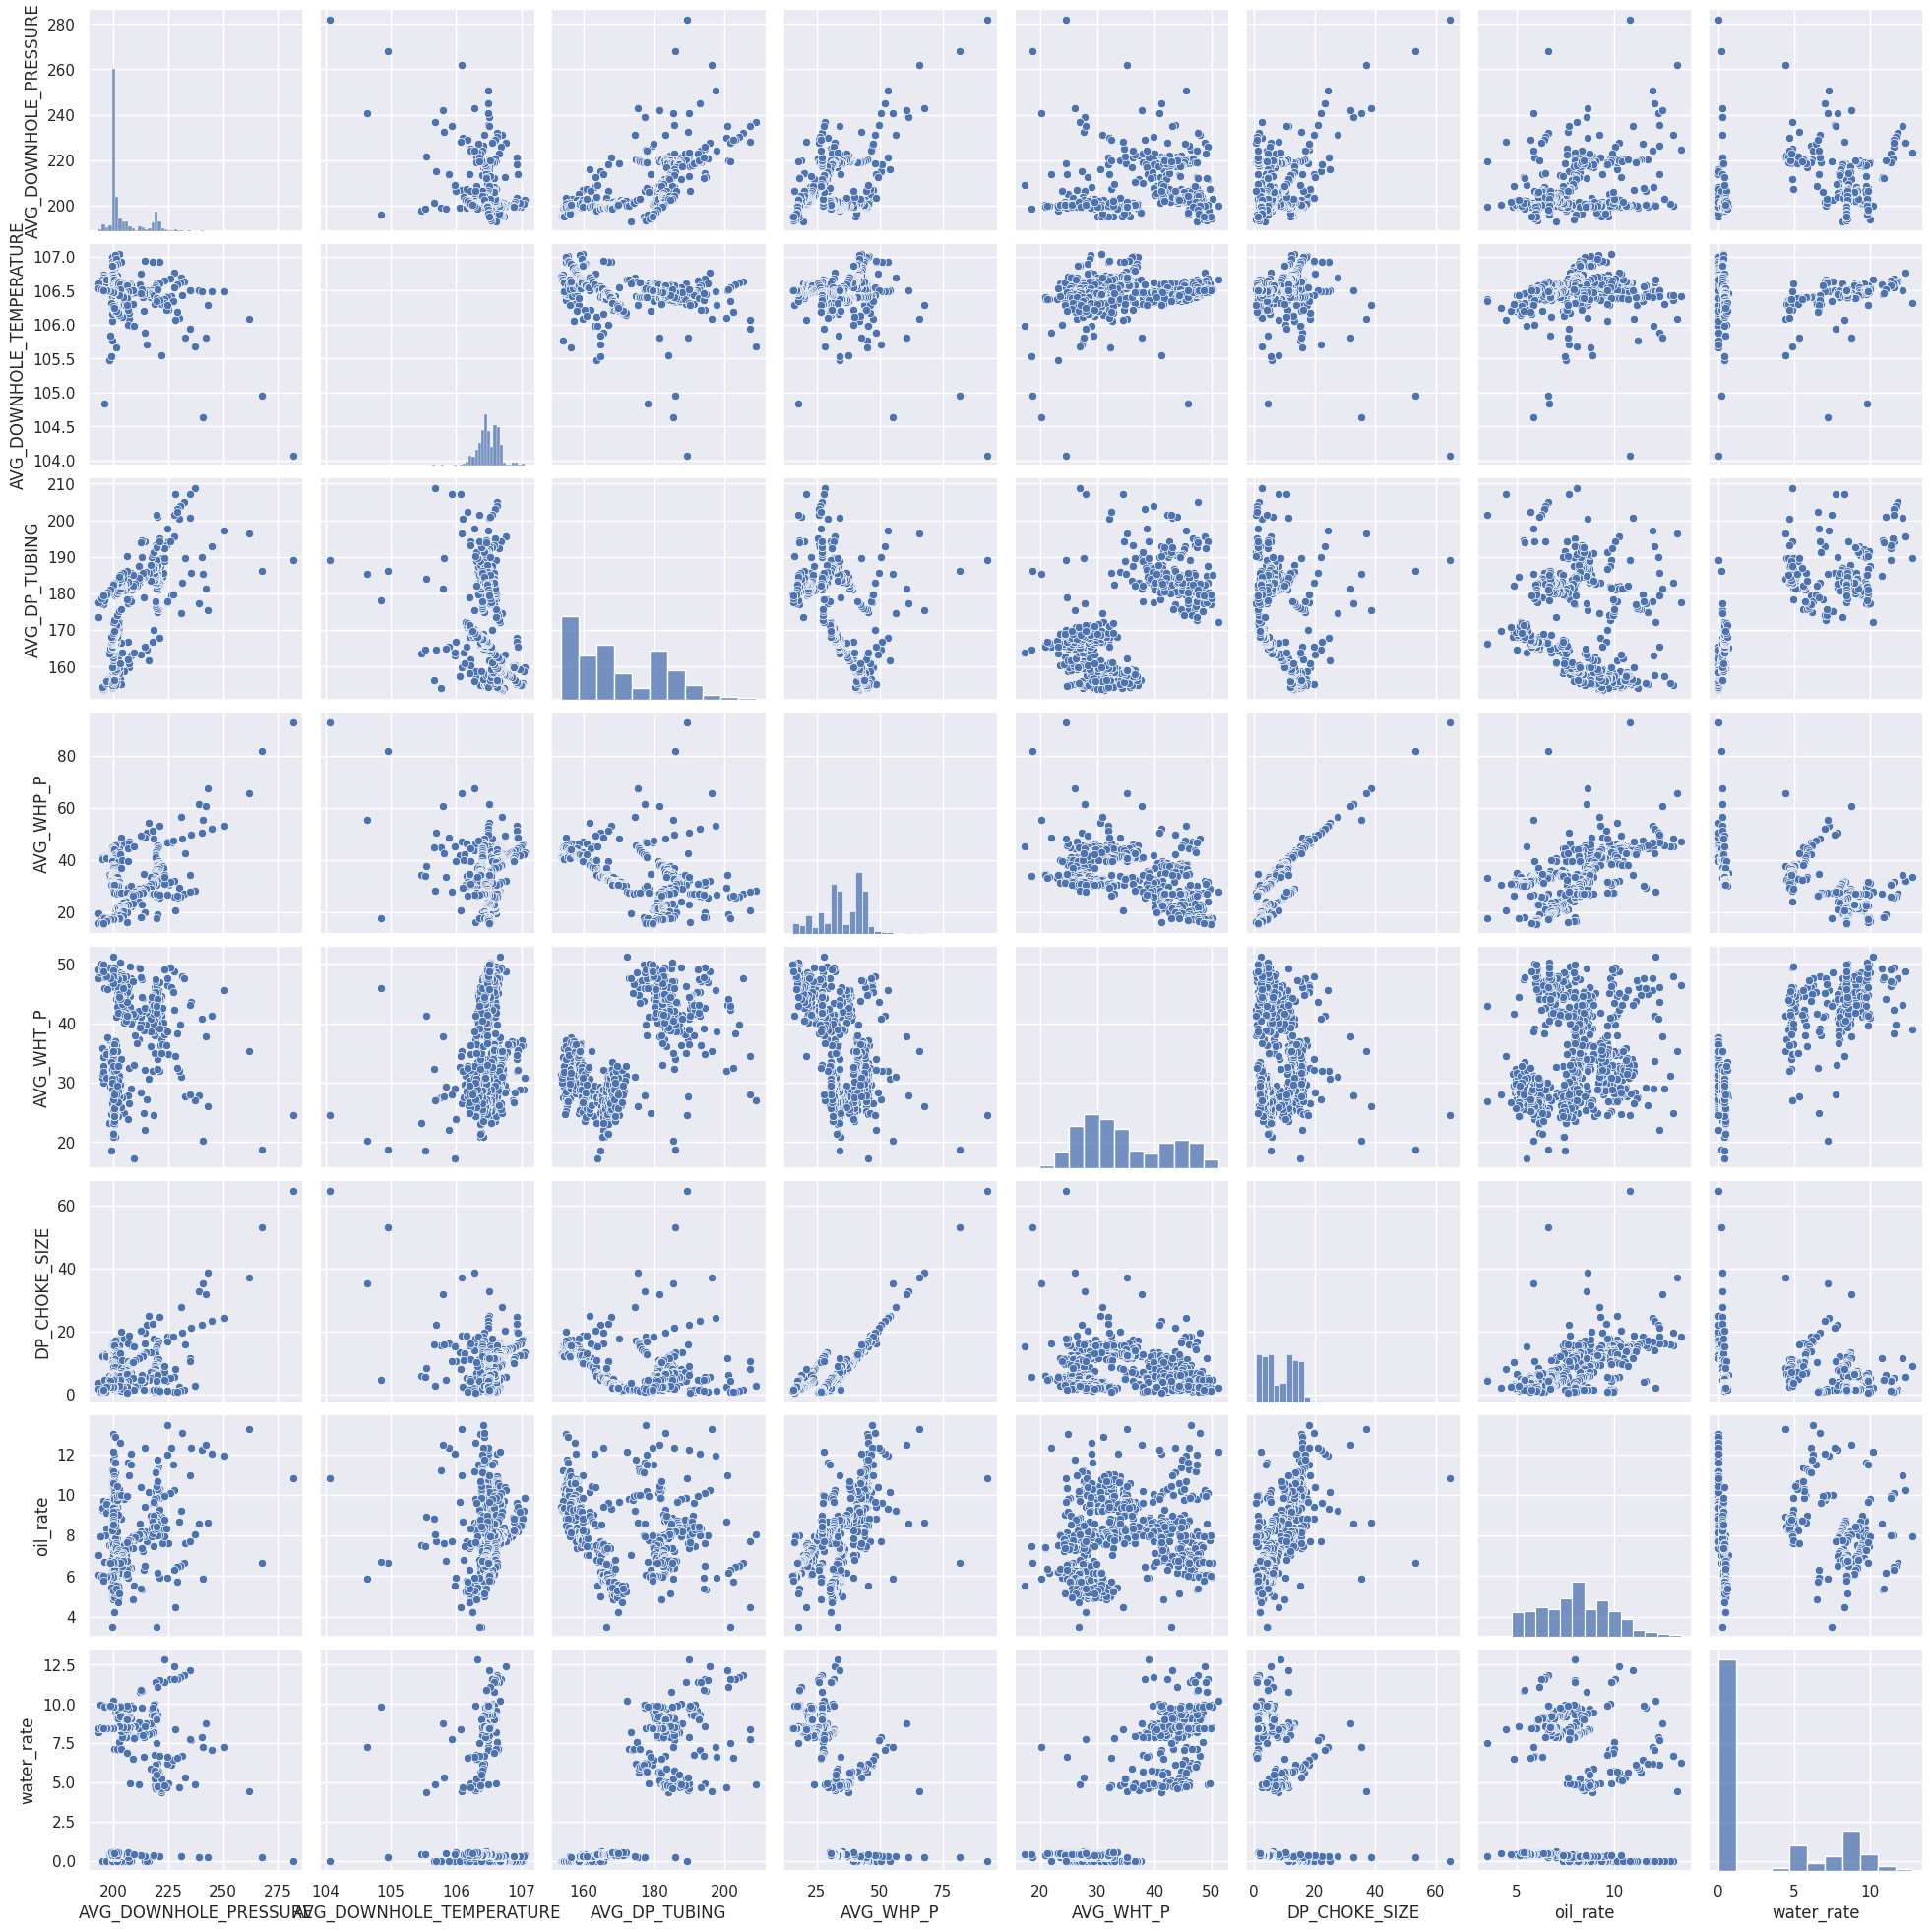

In [251]:
sns.pairplot(df);

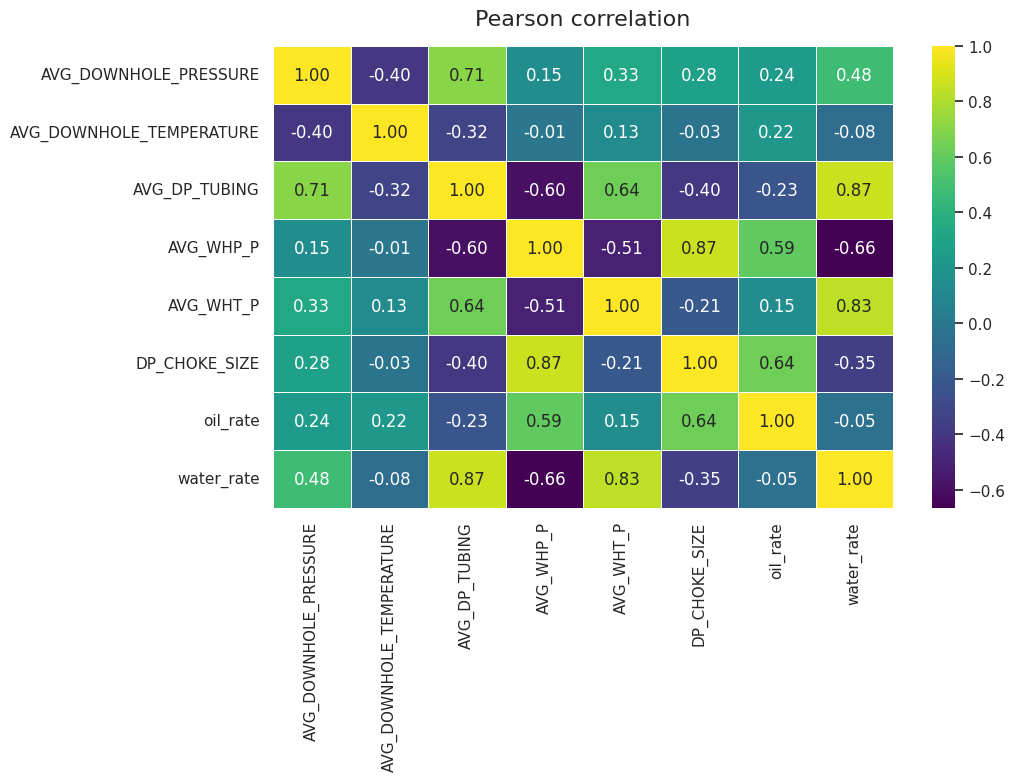

In [252]:
df_numeric = df.select_dtypes(include=["number"])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
plt.title("Pearson correlation", fontsize=16, pad=15)

plt.show()

#### we can conclude that the laest effective freatures if we use linear regression will be the average downhole pressure and temperature for this data

##Data Processing

Search for outliers

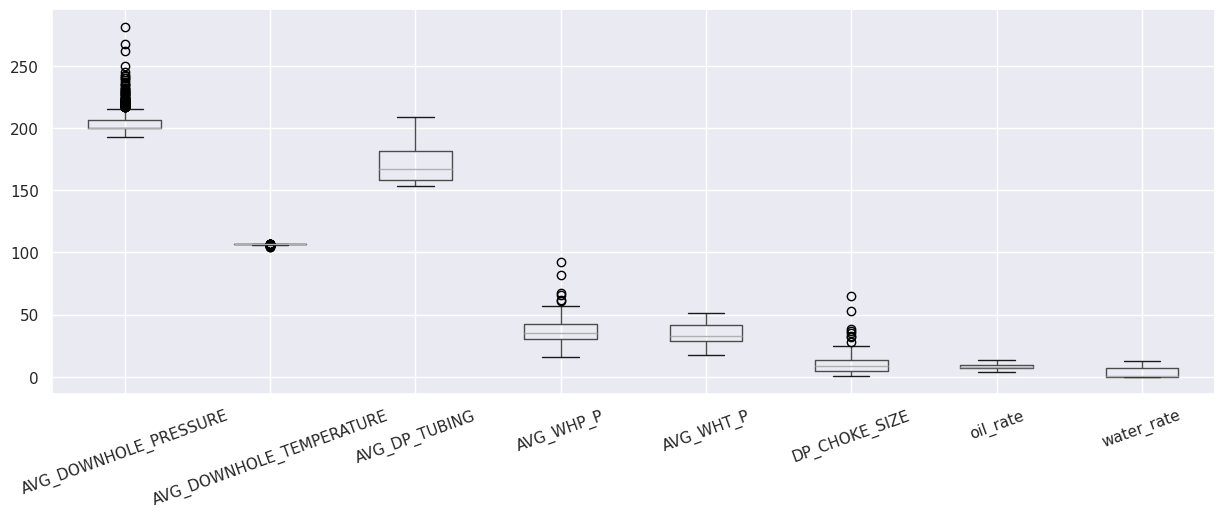

In [253]:
plt.figure(figsize=(15,5))
df.boxplot()
plt.xticks(rotation=20);

We will remove the 0 values and outliers

In [254]:
df = df[df!=0]
df = df[ df.AVG_WHP_P >0]
df = df[df.water_rate < 300]
df = df[df["AVG_DP_TUBING"] > 100]
df = df[ df["AVG_WHP_P"] >10 ]

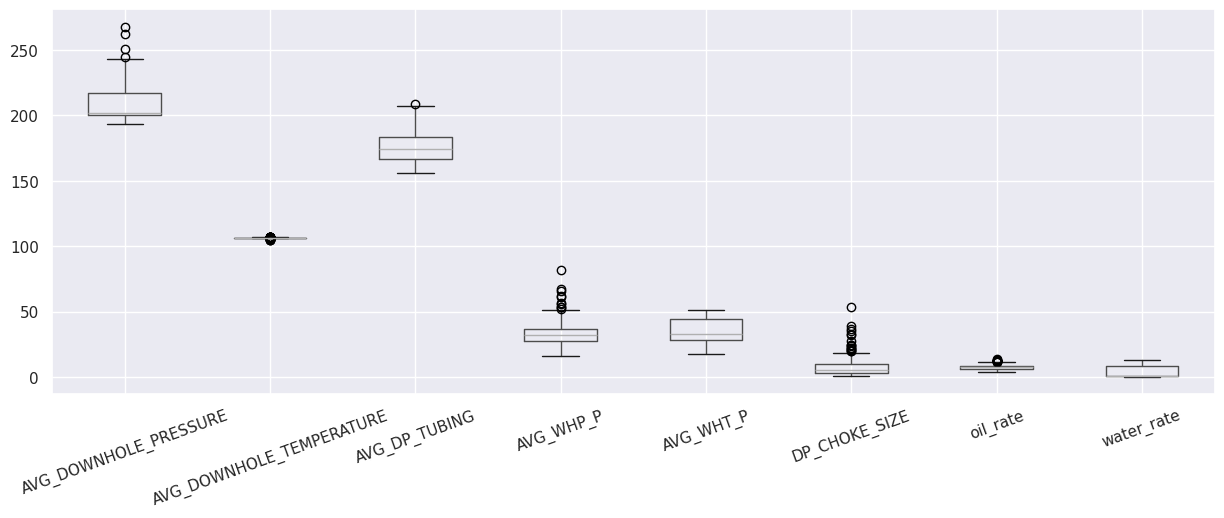

In [255]:
plt.figure(figsize=(15,5))
df.boxplot()
plt.xticks(rotation=20);

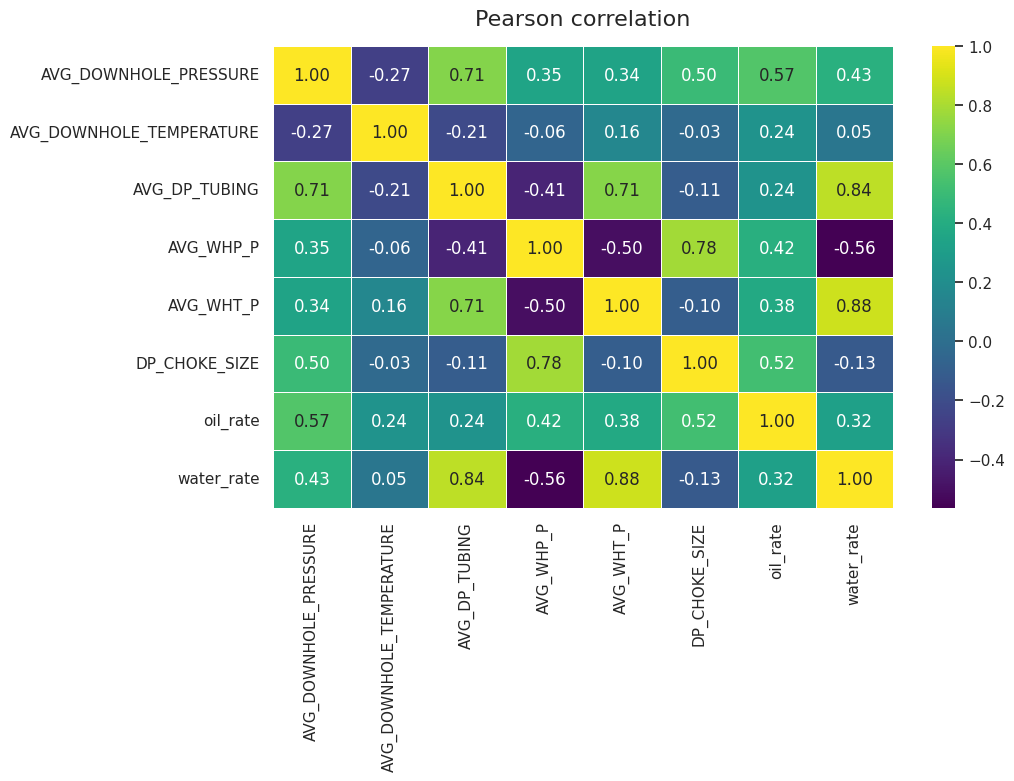

In [256]:
df_numeric = df.select_dtypes(include=["number"])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
plt.title("Pearson correlation", fontsize=16, pad=15)

plt.show()

Variation in the features with time

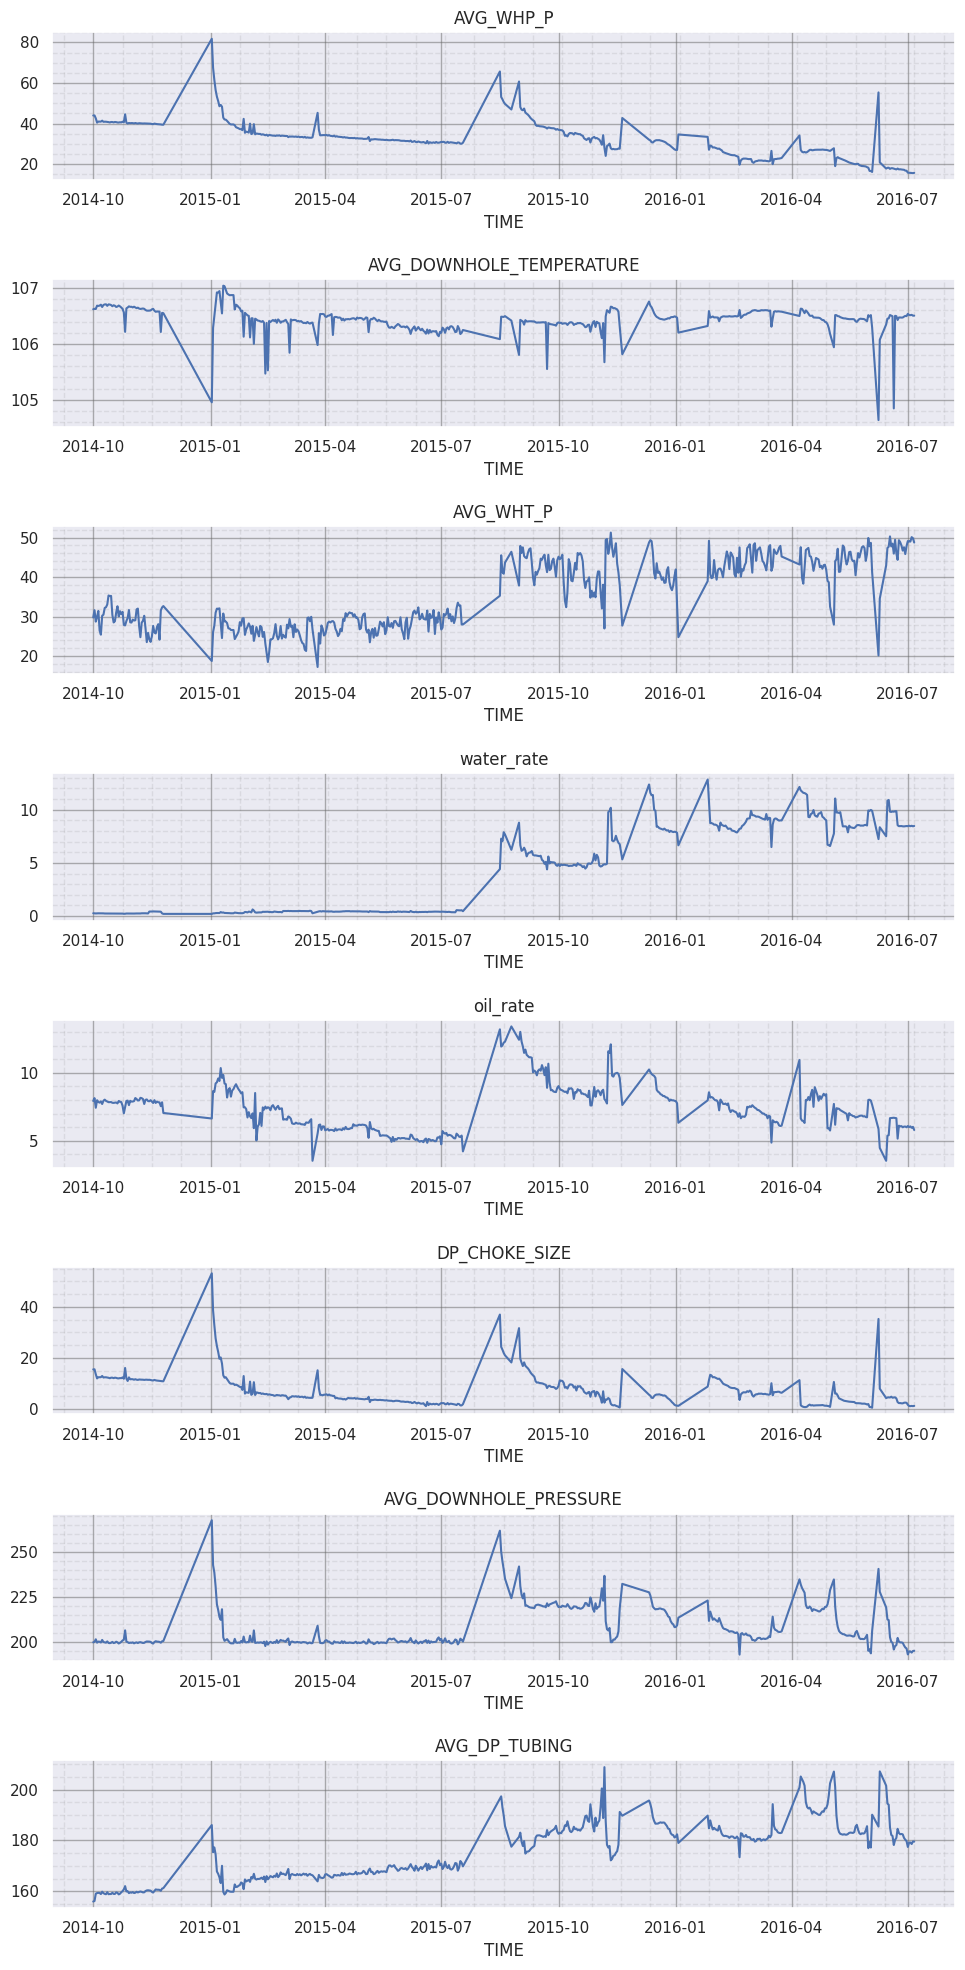

In [257]:

plt.figure(figsize= (10,20))
cols = set(list(df.columns)) - set(["DATEPRD"])

for i, col in enumerate(cols) :
    plt.subplot(len(cols),1,i+1)
    plt.plot( df["DATEPRD"], df[col])

    plt.xlabel("TIME" )
    plt.title(col)

    plt.grid( which="major", linestyle="-", alpha=.5, color="#6666")
    plt.minorticks_on()
    plt.grid( which="minor", linestyle="--", alpha=.2, color="#9999")

plt.tight_layout(pad=1.5)

## Build Machine Learning Models

Convert the date in timeline

In [258]:
df["days"] = (df["DATEPRD"] - df["DATEPRD"].min()).dt.days

In [259]:
X = df[["days",'AVG_DOWNHOLE_PRESSURE',"AVG_DOWNHOLE_TEMPERATURE",'AVG_DP_TUBING'
     ,'AVG_WHP_P','AVG_WHT_P','DP_CHOKE_SIZE']]
y = df[['oil_rate', 'water_rate']]


train_size=  int(.75 * len(X))
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

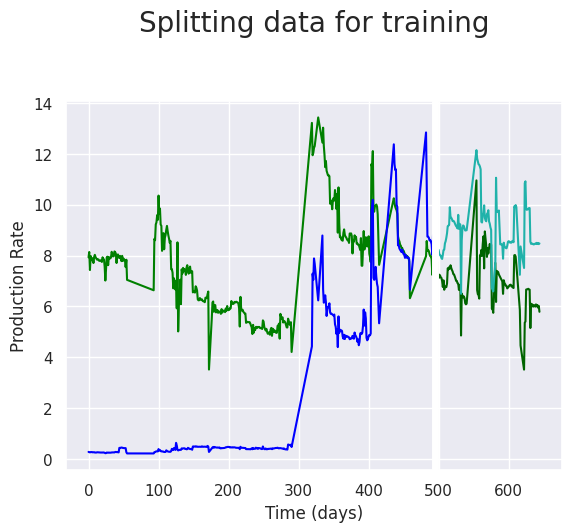

In [260]:
plt.title("Splitting data for training",fontsize=20,pad=50)
plt.plot(X_train["days"],y_train["oil_rate"],color="green")
plt.plot(X_train["days"],y_train["water_rate"],color="blue")
plt.plot(X_test["days"],y_test["oil_rate"],color="darkgreen")
plt.plot(X_test["days"],y_test["water_rate"],color="lightseagreen")
plt.xlabel("Time (days)")
plt.ylabel("Production Rate")
plt.axvline(x = X["days"].iloc[train_size], color = '#fff', label = 'axvline - full height',linewidth=5);
plt.annotate('Train-Data', xy=(600, 250), xytext=(600, 250),fontsize=18)
plt.annotate('Test-Data', xy=(600, 250),  xytext=(1100, 250),fontsize=18);


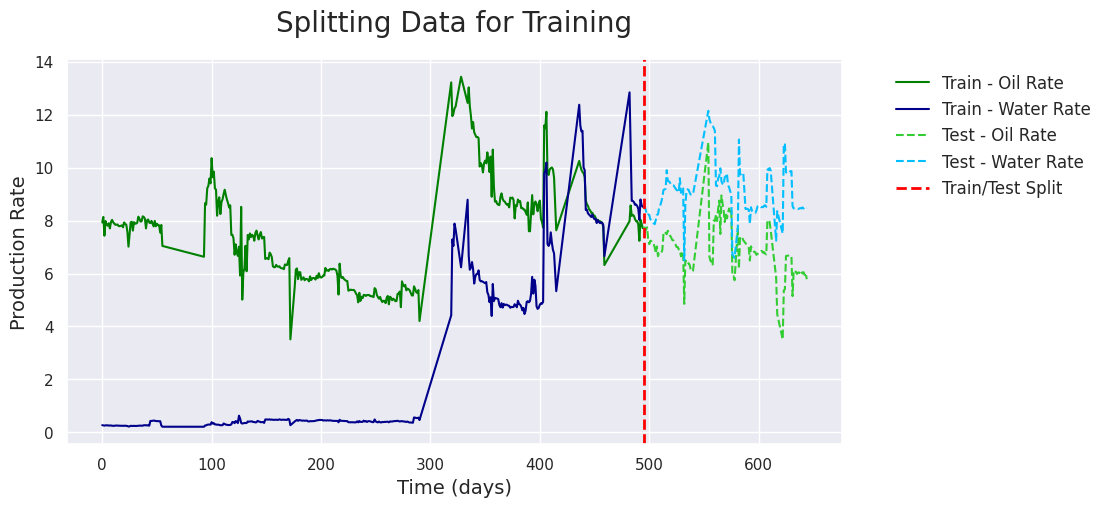

In [261]:
plt.figure(figsize=(10, 5))

plt.title("Splitting Data for Training", fontsize=20, pad=20)

plt.plot(X_train["days"], y_train["oil_rate"], color="green", linestyle="-", label="Train - Oil Rate")
plt.plot(X_train["days"], y_train["water_rate"], color="darkblue", linestyle="-", label="Train - Water Rate")

plt.plot(X_test["days"], y_test["oil_rate"], color="limegreen", linestyle="--", label="Test - Oil Rate")
plt.plot(X_test["days"], y_test["water_rate"], color="deepskyblue", linestyle="--", label="Test - Water Rate")

plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Production Rate", fontsize=14)

split_point = X["days"].iloc[train_size]
plt.axvline(x=split_point, color="red", linestyle="--", linewidth=2, label="Train/Test Split")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, facecolor="white", framealpha=1)


plt.show()

In [262]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

## XGBoost Model

In [263]:
xbg = XGBRegressor(max_depth=10,n_estimators=1000,objective="reg:squarederror",gamma=.3)
xbg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [264]:
def eval(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    oil_mae = mean_absolute_error(y_test["oil_rate"], y_pred[:, 0])
    oil_r2 = r2_score(y_test["oil_rate"], y_pred[:, 0])
    water_mae = mean_absolute_error(y_test["water_rate"], y_pred[:, 1])
    water_r2 = r2_score(y_test["water_rate"], y_pred[:, 1])

    print(f" Oil MAE: {oil_mae:.2f} , R²: {oil_r2:.2f}")
    print(f" Water MAE: {water_mae:.2f} , R²: {water_r2:.2f}")

    plt.figure(figsize=(14, 7))
    plt.title("Model Predictions vs. True Values", fontsize=18, pad=20)

    plt.plot(X_train["days"], y_train["oil_rate"], color="green", label="True Oil (Train)", alpha=0.7)
    plt.plot(X_train["days"], y_train["water_rate"], color="navy", label="True Water (Train)", alpha=0.7)
    plt.plot(X_test["days"], y_test["oil_rate"], color="darkgreen", label="True Oil (Test)", alpha=0.6)
    plt.plot(X_test["days"], y_test["water_rate"], color="darkblue", label="True Water (Test)", alpha=0.6)

    plt.plot(X_test["days"], y_pred[:, 0], color="darkred", linestyle="--", linewidth=1.5, label="Predicted Oil")  # Naranja
    plt.plot(X_test["days"], y_pred[:, 1], color="#0096C7", linestyle="--", linewidth=1.5, label="Predicted Water")  # Morado

    split_point = X["days"].iloc[train_size]
    plt.axvline(x=split_point, color="red", linestyle="-", linewidth=2, label="Prediction Start")

    plt.xlabel("Time (Days)", fontsize=14)
    plt.ylabel("Production Rate", fontsize=14)

    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12, framealpha=1)



 Oil MAE: 1.48 , R²: -2.34
 Water MAE: 0.86 , R²: -0.72


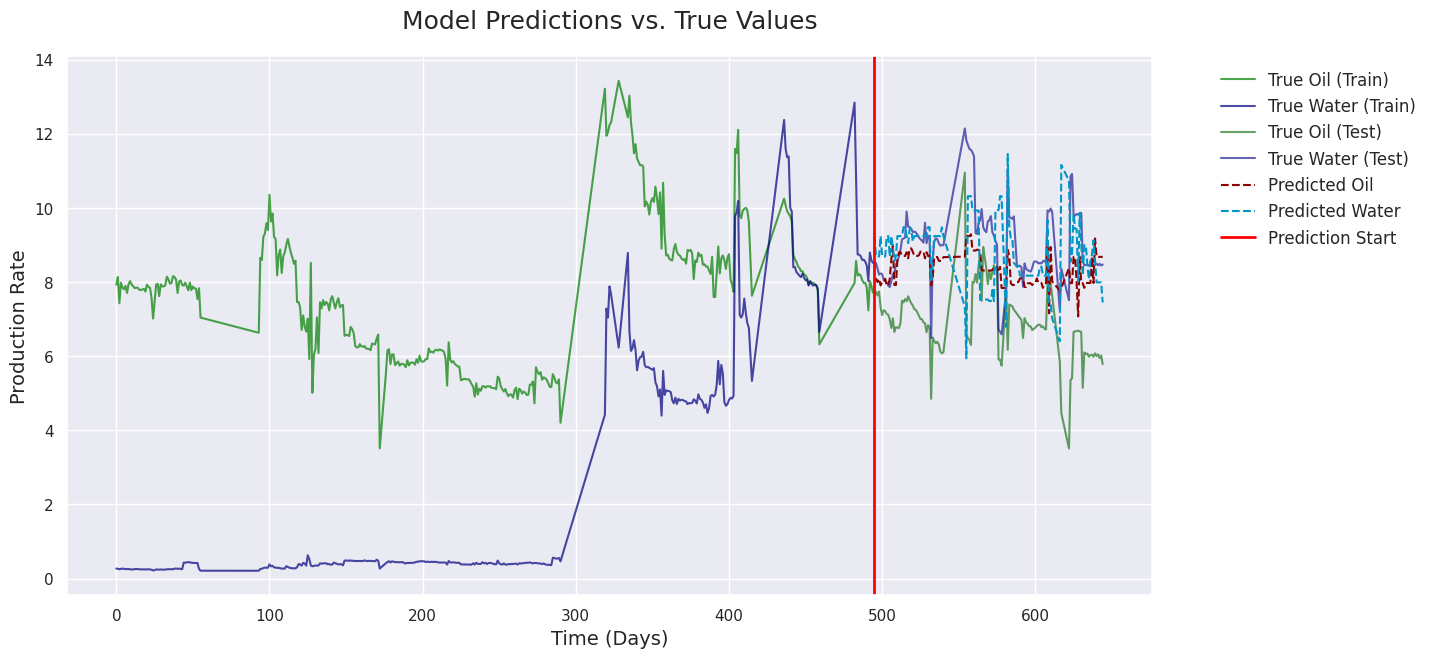

In [265]:
# evaluate the xbgboost
eval(xbg)

We can observe that the model performs poorly in predicting water production but does a fairly good job in forecasting oil production.

## linear regression

 Oil MAE: 0.93 , R²: -0.63
 Water MAE: 1.05 , R²: -0.58


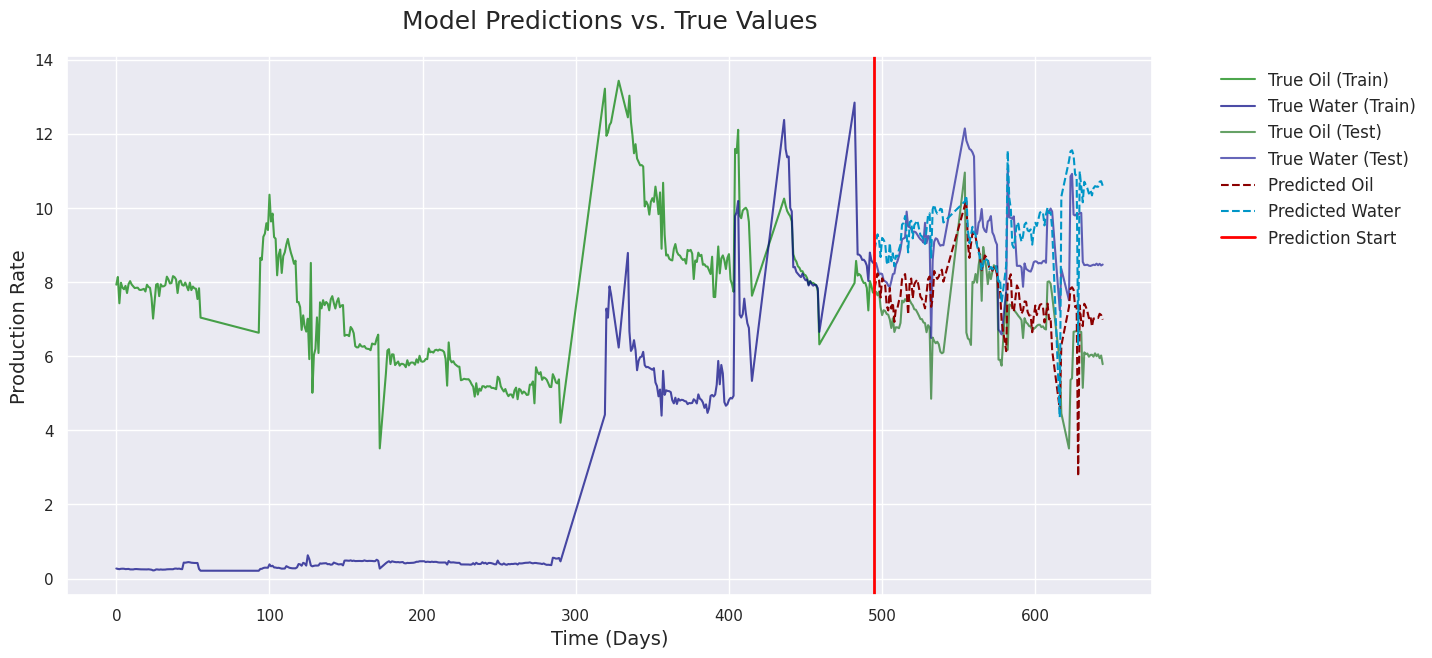

In [266]:
lr = LinearRegression()
lr.fit(X_train,y_train)
eval(lr)

##Integrate Both Models
Use XGBoost for predicting oil\
Apply Linear Regression for water

In [267]:
def combined_model(X_train,y_train):
    lr = LinearRegression()
    xbg = XGBRegressor(max_depth=10,n_estimators=1000,objective="reg:squarederror",gamma=.3)
    xbg.fit(X_train,y_train)
    lr.fit(X_train,y_train)

In [268]:
class CombinedModel:
    def __init__(self):
        self.xgb = XGBRegressor(max_depth=10, n_estimators=1000, objective="reg:squarederror", gamma=0.3)
        self.lr = LinearRegression()

    def train(self, X_train, y_train):
        self.x_train = X_train
        self.y_train = y_train
        self.xgb.fit(X_train, y_train)
        self.lr.fit(X_train, y_train)

    def predict(self, X_test):
        self.x_test = X_test
        self.oil_pred = self.xgb.predict(X_test)[:, 0]
        self.water_pred = self.lr.predict(X_test)[:, 1]

    def evaluate(self, y_test):
        self.y_test = y_test
        oil_mae = mean_absolute_error(y_test["oil_rate"], self.oil_pred)
        oil_mape = mean_absolute_percentage_error(y_test["oil_rate"], self.oil_pred)
        water_mae = mean_absolute_error(y_test["water_rate"], self.water_pred)
        water_mape = mean_absolute_percentage_error(y_test["water_rate"], self.water_pred)
        print(f"Oil MAE: {oil_mae}, MAPE: {oil_mape}")
        print(f"Water MAE: {water_mae}, MAPE: {water_mape}")

    def show_results(self):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=300, sharex=True)

        # Oil production plot
        axes[0].set_title("Oil Production Prediction", fontsize=16, pad=15)
        axes[0].plot(self.x_train["days"], self.y_train["oil_rate"], color="#D35400", alpha=0.5, label="Training Oil")
        axes[0].plot(self.x_test["days"], self.y_test["oil_rate"], color="#D35400", label="True Oil", linewidth=2)
        axes[0].plot(self.x_test["days"], self.oil_pred, color="#F4D03F", linestyle="dashed", label="Predicted Oil", linewidth=2)
        axes[0].axvline(x=self.x_train["days"].iloc[-1], color="red", linestyle="dashed", linewidth=2, label="Prediction Start")
        axes[0].set_ylabel("Production Rate", fontsize=12)
        axes[0].legend(loc="upper left", fontsize=10, frameon=False)

        # Water production plot
        axes[1].set_title("Water Production Prediction", fontsize=16, pad=15)
        axes[1].plot(self.x_train["days"], self.y_train["water_rate"], color="#1F618D", alpha=0.5, label="Training Water")
        axes[1].plot(self.x_test["days"], self.y_test["water_rate"], color="#1F618D", label="True Water", linewidth=2)
        axes[1].plot(self.x_test["days"], self.water_pred, color="#17A589", linestyle="dashed", label="Predicted Water", linewidth=2)
        axes[1].axvline(x=self.x_train["days"].iloc[-1], color="red", linestyle="dashed", linewidth=2, label="Prediction Start")
        axes[1].set_xlabel("Time (days)", fontsize=12)
        axes[1].set_ylabel("Production Rate", fontsize=12)
        axes[1].legend(loc="upper left", fontsize=10, frameon=False)

        plt.tight_layout()
        plt.savefig("final2.png", bbox_inches="tight")
        plt.show()


Oil MAE: 1.484070269636802, MAPE: 0.23387855288633103
Water MAE: 1.0488093963539407, MAPE: 0.1188023503757682


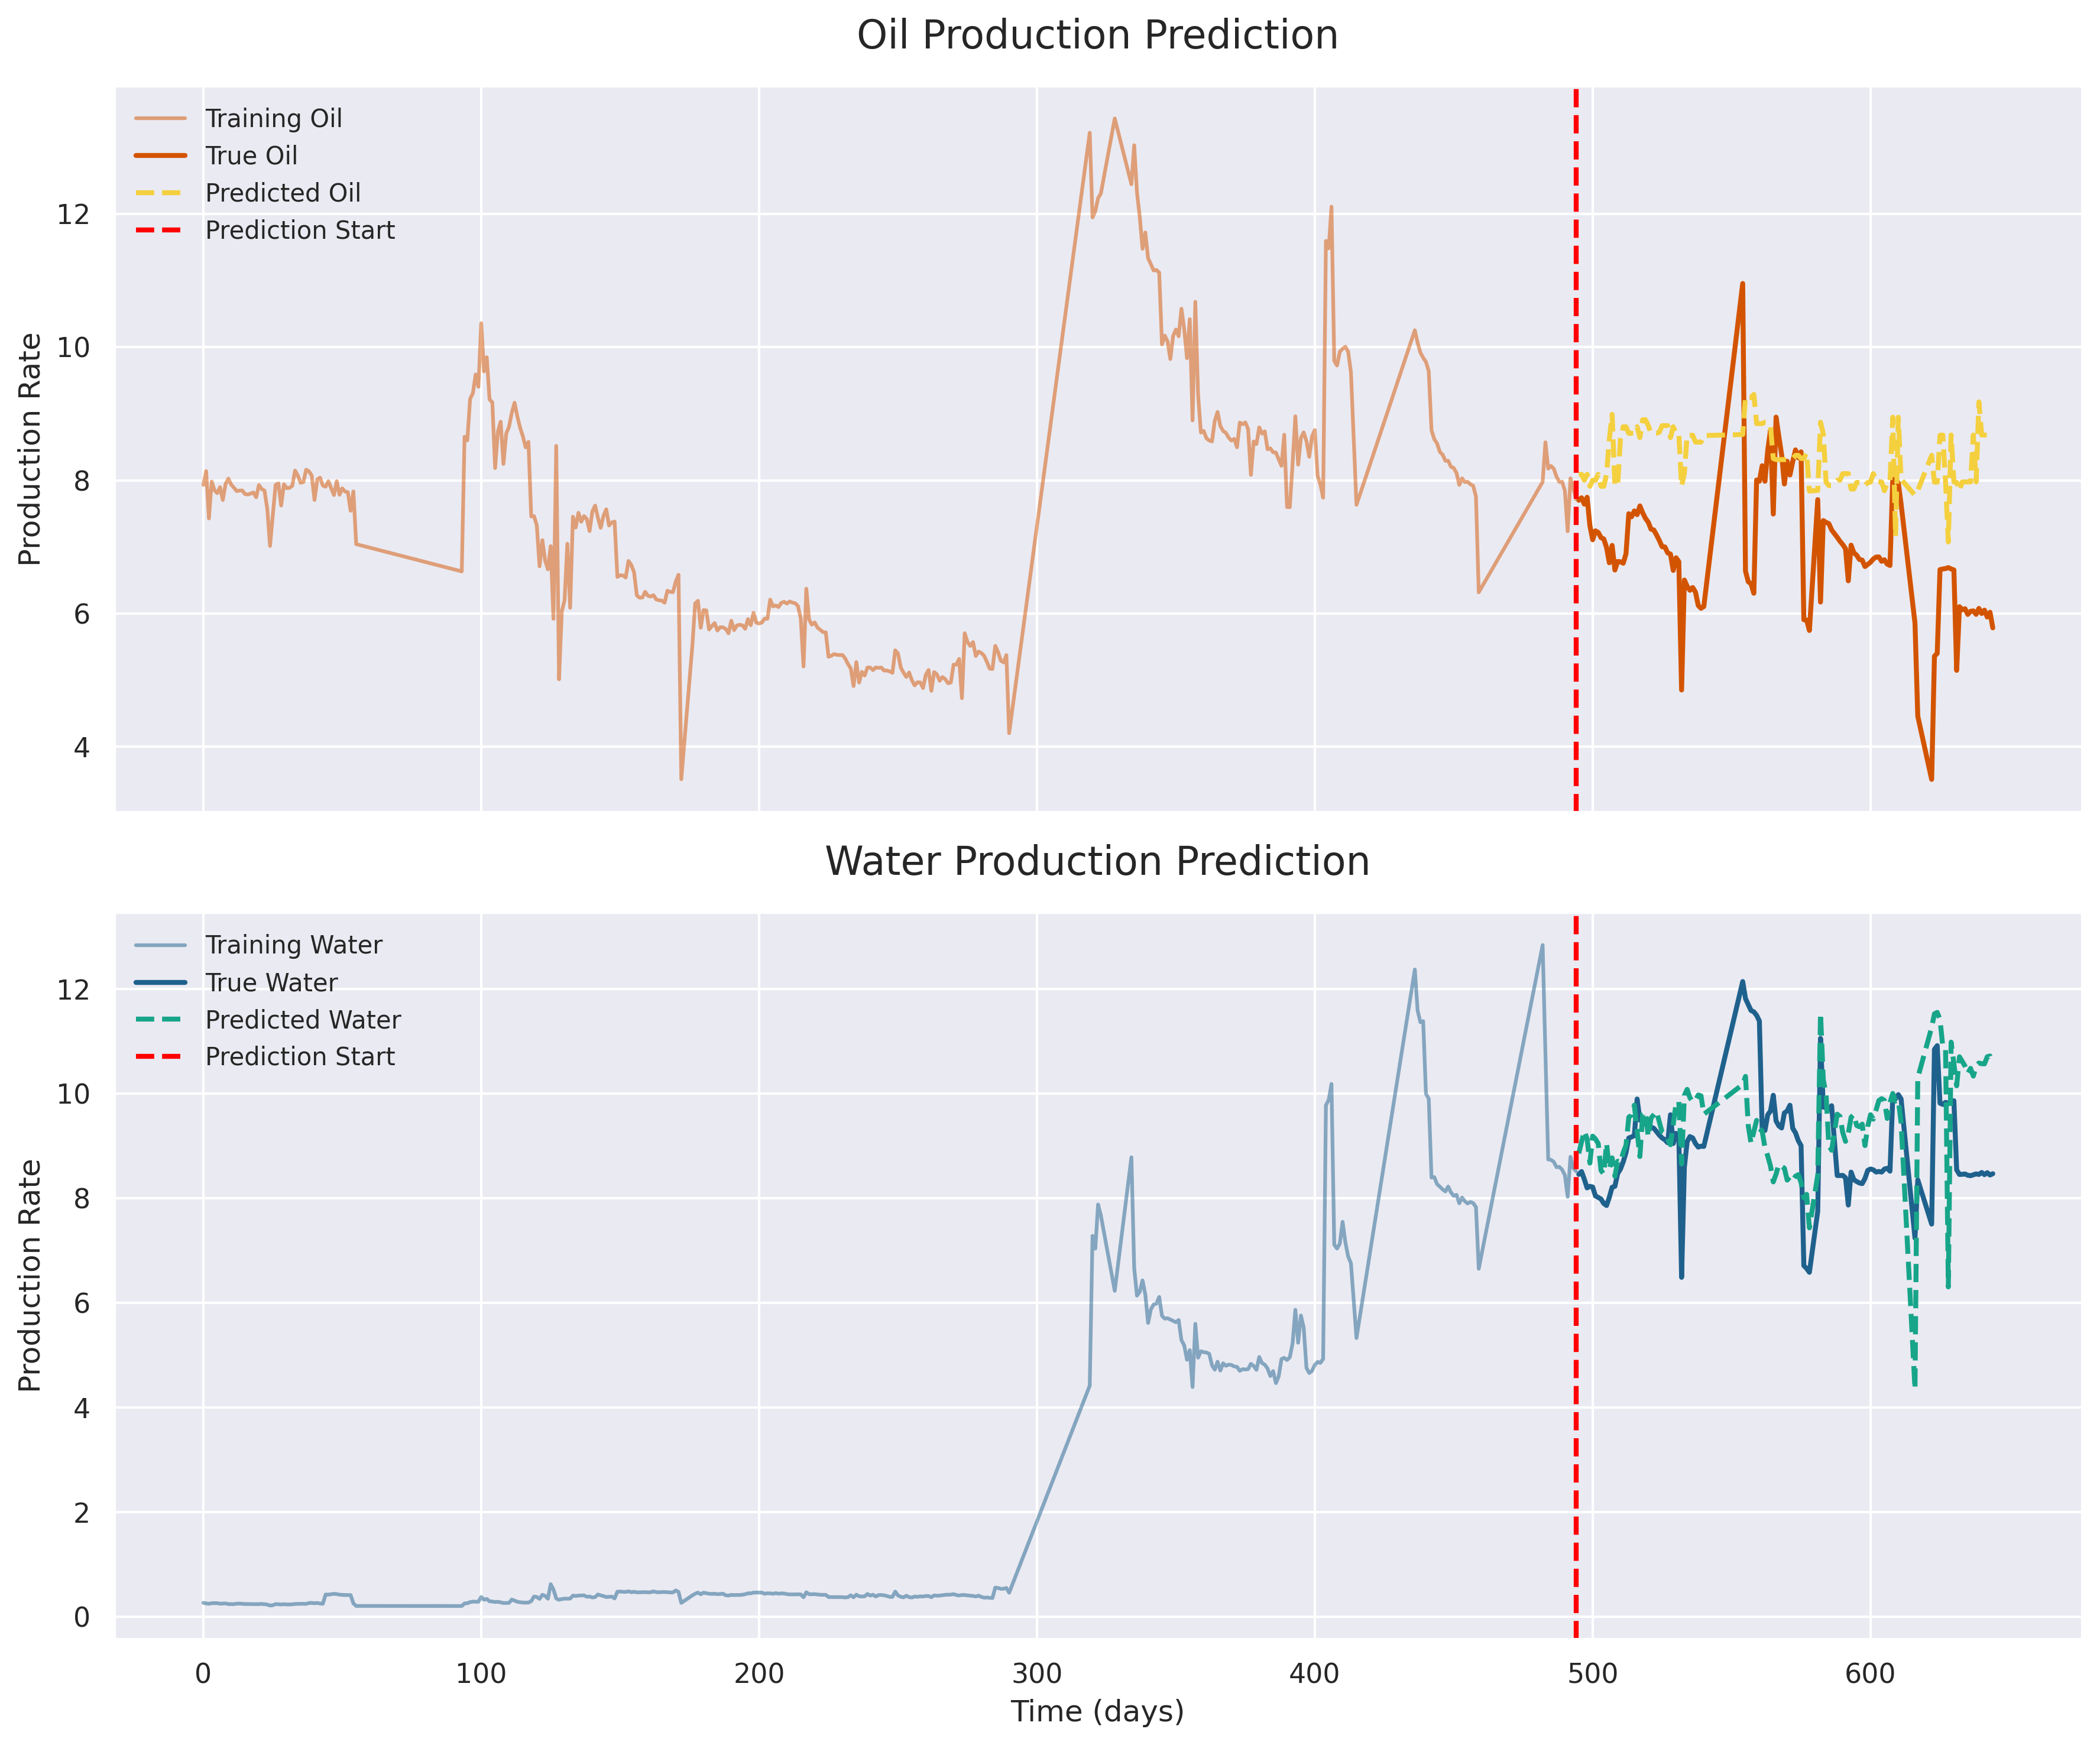

In [269]:
model = CombinedModel()
model.train(X_train,y_train)
model.predict(X_test)
model.evaluate(y_test)
model.show_results()